# HRRR Zarr Example
## Download an analysis variable, whole grid, 24 hours

This example shows a fast and convenient way to download and merge multiple hours of analysis data from the HRRR Zarr S3 archive. It should be easy to adapt for cloud computing using Dask as well.

If you only want data at a single grid point or a small region, please refer to other examples on how to download data by chunk. Doing so is much faster, especially as you look at more hours or variables.

In [14]:
import s3fs
import xarray as xr
import metpy
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
fs = s3fs.S3FileSystem(anon=True)

Because the HRRR Zarr archive contains metadata (such as the grid information) in a group and the actual data in a subgroup, the xarray open_dataset function doesn't work if all you want to do is open data for a single hour––for that, call xr.open_mfdataset instead. 

But xr.open_dataset is faster and has the capability to lazy-load, so since we're already going to be combining multiple datasets, let's go ahead and use that function, which will work equally well if we feed it the group url (it'll just load the metadata) as if we pass the subgroup url (it'll load the data variable but not the metadata).

In [15]:
def load(url, time=None):
    # Download the data from S3. May be lazy.
    ds = xr.open_dataset(s3fs.S3Map(url, s3=fs), engine="zarr")
    ds["time"] = time
    ds = ds.set_coords("time")
    # Later on we use metpy functions that expect the grid variables to be x and y
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    return ds

Now we actually create the dataset we want in 3 steps:
- Download the grid data
- Download the actual data for the variable of interest
- Add the grid data to the dataset and enhance with metpy functions that understand the coordinate reference system

In [16]:
def load_combined_dataset(start_date, num_hours, level, param_short_name):
    group_url_format = f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}"
    
    # Get data at the group level just once so we have the grid data
    group_url = start_date.strftime(group_url_format)
    grid = load(group_url)
    
    # Load and combine the data for each hour
    datasets = []
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        subgroup_url = time.strftime(group_url_format) + f"/{level}"
        datasets.append(load(subgroup_url, time=time))
    ds = xr.concat(datasets, dim="time", combine_attrs="override")
    
    # Add the grid data to the combined dataset
    ds["x"] = grid["x"]
    ds["y"] = grid["y"]  
    ds = ds.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", longitude_of_central_meridian=-97.5,
                                 latitude_of_projection_origin=38.5,
                                 standard_parallel=38.5)
    ds = ds.metpy.assign_latitude_longitude()
    
    return ds

Running this for 24 hours takes about half a minute.

In [20]:
%%time
ds = load_combined_dataset(datetime.datetime(2021, 4, 1), 24, "1000mb", "TMP")

CPU times: user 9.64 s, sys: 378 ms, total: 10 s
Wall time: 32 s


It seems to do some slight lazy-load, since when we do a test computation (getting the standard deviation over time) it takes 1.5 seconds. When all the data is loaded, the computation takes around 50 ms.

In [21]:
%%time
std_dev = ds.TMP.std(dim="time")

CPU times: user 1.49 s, sys: 48.3 ms, total: 1.54 s
Wall time: 1.54 s


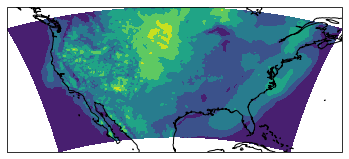

In [22]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(std_dev.longitude, std_dev.latitude, std_dev)
ax.coastlines()

plt.show()

**Troubleshoot:** In my Jupyter notebook setup, the pyproj package gives the following error when it tries looking up the projection info:

```
CRSError: Invalid datum string: urn:ogc:def:datum:EPSG::6326: (Internal Proj Error: proj_create: SQLite error on SELECT name, ellipsoid_auth_name, ellipsoid_code, prime_meridian_auth_name, prime_meridian_code, publication_date, frame_reference_epoch, deprecated FROM geodetic_datum WHERE auth_name = ? AND code = ?: no such column: publication_date)
```

I believe this is because I run Jupyter from a conda environment that's different than the kernel Jupyter is using. In any case, there's an easy fix:

In [2]:
import pyproj
pyproj.datadir.set_data_dir("/Users/<me>/.conda/envs/<this notebook's kernel env>/share/proj")